In [11]:
# imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

In [12]:
# create a dataset w/ 10% each of Monday-WorkingHours and Friday-Afternoon-DDoS
INPUT_FILE_MONDAY = '../datasets/Monday-WorkingHours.pcap_ISCX.csv'
INPUT_FILE_THURSDAY_WEBATTACK = '../datasets/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv'
INPUT_FILE_FRIDAY_DDOS = '../datasets/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv'
INPUT_FILE_FRIDAY_PORTSCAN = '../datasets/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv'

cols_to_read = [
    'Destination Port', 
    'Flow Duration', 
    'Total Fwd Packets', 
    'Total Backward Packets', 
    'Flow Bytes/s', 
    'Flow Packets/s', 
    'Flow IAT Mean', 
    'Flow IAT Max', 
    'Packet Length Mean', 
    'Packet Length Std', 
    'Average Packet Size', 
    'SYN Flag Count', 
    'ACK Flag Count', 
    'PSH Flag Count', 
    'FIN Flag Count', 
    'Label'
]

df_monday = pd.read_csv(INPUT_FILE_MONDAY, on_bad_lines='skip')
df_monday.columns = df_monday.columns.str.strip()
df_monday = df_monday[df_monday['Label'] == 'BENIGN'][cols_to_read]
df_monday = df_monday.sample(n=30000, random_state=42)

df_thursday = pd.read_csv(INPUT_FILE_THURSDAY_WEBATTACK, on_bad_lines='skip')
df_thursday.columns = df_thursday.columns.str.strip()
df_thursday = df_thursday[cols_to_read]
df_thursday = df_thursday[df_thursday['Label'].str.contains('Web Attack', na=False)]

df_friday_ddos = pd.read_csv(INPUT_FILE_FRIDAY_DDOS, on_bad_lines='skip')
df_friday_ddos.columns = df_friday_ddos.columns.str.strip()
df_friday_ddos = df_friday_ddos[cols_to_read]
df_friday_ddos = df_friday_ddos[df_friday_ddos['Label'].str.contains('DDoS', na=False)]
df_friday_ddos = df_friday_ddos.sample(n=20000, random_state=42)

df_friday_portscan = pd.read_csv(INPUT_FILE_FRIDAY_PORTSCAN, on_bad_lines='skip')
df_friday_portscan.columns = df_friday_portscan.columns.str.strip()
df_friday_portscan = df_friday_portscan[cols_to_read]
df_friday_portscan = df_friday_portscan[df_friday_portscan['Label'].str.contains('PortScan', na=False)]
df_friday_portscan = df_friday_portscan.sample(n=20000, random_state=42)

df = pd.concat([df_monday, df_thursday, df_friday_ddos, df_friday_portscan])
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
# length of dataframe
display(len(df))

# fix for multiple categories of web attacks
df['Label'] = df['Label'].replace({
    'Web Attack � Brute Force': 'Web Attack',
    'Web Attack � Sql Injection': 'Web Attack',
    'Web Attack � XSS': 'Web Attack'
})

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

72180

In [13]:
# Label Encoding
# BENIGN: 0
# DDoS: 1
# PortScan: 2
# Web Attack: 3
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])
mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print('Mapping created: ', mapping)

joblib.dump(le, '../joblib_dumps/label_encoder.joblib')

Mapping created:  {'BENIGN': np.int64(0), 'DDoS': np.int64(1), 'PortScan': np.int64(2), 'Web Attack': np.int64(3)}


['../joblib_dumps/label_encoder.joblib']

In [14]:
# train the model
X = df.drop('Label', axis=1)
y = df['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
print("Training RandomForest Model...")
rf.fit(X_train, y_train)
print("RandomForest Model trained!")

joblib.dump(rf, '../joblib_dumps/randomforest.joblib')

Training RandomForest Model...
RandomForest Model trained!


['../joblib_dumps/randomforest.joblib']

Random Forest Model Results:
  Training Accuracy: 1.0000
  Test Accuracy:     0.9978
  Test Precision:    0.9978
  Test Recall:       0.9978
  Test F1 Score:     0.9978


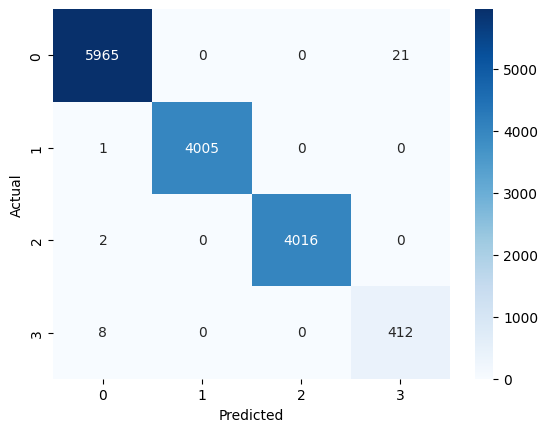

In [15]:
# display tests
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

print("Random Forest Model Results:")
print(f"  Training Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"  Test Accuracy:     {accuracy_score(y_test, y_test_pred):.4f}")
print(f"  Test Precision:    {precision_score(y_test, y_test_pred, average='weighted'):.4f}")
print(f"  Test Recall:       {recall_score(y_test, y_test_pred, average='weighted'):.4f}")
print(f"  Test F1 Score:     {f1_score(y_test, y_test_pred, average='weighted'):.4f}")

cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()